## Quantifying Difficulty of [L.A. Times Daily Crosswords](http://games.latimes.com/games/daily-crossword/): Are Mondays Harder than Tuesdays?

One of the ways I keep in touch with a good [college](http://www.unc.edu/) friend of mine is by occasionally doing crosswords over skype. Back when we were in school together, we would do the crossword in the school paper (which used the same crosswords as the L.A. Times) over lunch. We definitely aren't experts, but we could usually manage doing Monday, Tuesday, and Wednesday puzzles (crosswords get more difficult throughout the week, ending with Sunday being impossible for a simpleton like myself). 

#### The Question

For years now, we've had a hunch that the Monday puzzles are actually slightly harder than the Tuesdays, but haven't had a way to validate it. Unfortunately I haven't kept any data on our own solving ability (solve times, puzzle completion), though it would probably be statistics limited, and furthermore frought with outliers (taking large breaks to chat about other things, for example).

#### The Data

Since many people nowadays do the crossword online (as my friend and I do), I was hoping to get my hands on a database of user information... but to the best of my knowledge, this is proprietary and not publicly accessible. Therefore, I'll have to find a simpler solution.

Lucky me, I found [this blog](http://www.laxcrossword.com/) written by a man named [Bill Butler](http://www.laxcrossword.com/about), who is essentially a professional crossword solver. He posts in his blog each day the solution to the day's puzzle, along with the time he took to solve the puzzle. As I'll show in this post, he is remarkably consistent, and solves puzzles several times faster than my friend and I do.

#### The Analysis

My general approach to determine crossword difficulty as a function of day is to scrape through Bill's past blog posts, extract the time and day of the week for each puzzle, wrangle the data into a usable format ([pandas](http://pandas.pydata.org/) dataframe), and crunch some numbers. I'll note that in my past blog posts, I've been transparent about all of the code I've used. In this case, most of the web scraping is remarkably similar to [my post on John Bartholomew's influence on a popular chess website](http://blog.davidkaleko.com/john-bartholomew-lichess-influence.html), so I'll hide it for readability.


In [1]:
#ignore
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime as dt
import urllib2
import re
import numpy as np
import pandas as pd
from BeautifulSoup import BeautifulSoup

# Utility functions

def getSoup(myurl):
    req = urllib2.Request(myurl)#, headers={'User-Agent' : "Magic Browser"}) 
    con = urllib2.urlopen( req )
    soup = BeautifulSoup( con ) 
    # For some reason, many times the page is mostly blank with a link
    # called "Continue Reading" which has  most of the info ...
    # Let's first check the page if there is a "Continue Reading" link,
    # then follow that link if it exists.
    allp = soup.findAll('p')
    continueLinks = [x.find('a') for x in allp if 'Continue reading' in x.getText()]
    if len(continueLinks) > 1:
        exceptionText = "uhh continueLinks length > 1. It has length %d." % len(continueLinks)
        print continueLinks
        raise Exception(exceptionText)
    # If there is a continue link, overwrite the previous soup
    elif len(continueLinks) == 1:
        newurl = continueLinks[0].get('href')
        #print " Following \"Continue\" link to new url:",newurl
        req = urllib2.Request(newurl)#, headers={'User-Agent' : "Magic Browser"}) 
        con = urllib2.urlopen( req )
        soup = BeautifulSoup( con )
        
    return soup

def getBillsTimeSeconds(mysoup):
    
    allp = mysoup.findAll('p')
    # Look for a line containing 'Bill' and 'time'.
    allBillLines = [ x.getText() for x in allp \
                    if 'time:' in x.getText().lower() and \
                    'bill' in x.getText().lower() ]# and \
                    #x.strong ]
        
    # There are often several such lines (especially including user comments)
    # So let's take only the lines that have lines like: "5m 32s" in them
    # (using regex here)
    goodBillTimes = []
    for line in allBillLines:
        res = re.search('\d+m \d+s', line)
        if res:
            goodBillTimes.append(res.group())        
    
    if len(goodBillTimes) != 1:
        exceptionText = "uhh goodBillTimes length != 1. It has length %d." % len(goodBillTimes)
        raise Exception(exceptionText)

    BillTime = goodBillTimes[0]
    #BillTime = BillTime[BillTime.find(':')+1:]
    BillTime = (dt.datetime.strptime(BillTime,'%Mm %Ss') - \
        dt.datetime(1900,1,1)).total_seconds()
    
    return BillTime

def getDay(mysoup):
    allheader = mysoup.findAll('header')
    entryHeaders = [ x.getText() for x in allheader if x['class'] == 'entry-header']
    if len(entryHeaders) != 1:
        exceptionText = "uhh more than one entry header on this page!"
        raise Exception(exceptionText)
        
    day = entryHeaders[0][entryHeaders[0].rfind(',')+2:]
    return day

def getAuthor(mysoup):
    allp = mysoup.findAll('p')
    setterp = [ x.getText() for x in allp \
               if 'setter' in x.getText().lower() or \
                  'constructed' in x.getText().lower() ]
    
    setter = None
    for line in setterp:
        res = re.search(':\S+ \S+', line)
        if res:
            if setter is None: setter = res.group()[1:]
            else:
                print "WTFFFF"
    if 'THEME' in setter:
        setter = setter[:setter.find('THEME')]
        
    return setter


I've hidden some cells in this notebook where I define functions that take as input a [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) object, then scrape the webpage to return a specific thing. They throw an exception when they fail (for example, [in the one drastically different blog post](http://www.laxcrossword.com/2016/05/laxcrosswordcom-is-moving.html) in which Bill doesn't solve a puzzle but instead announces changes to the blog formatting). Conveniently, each of Bill's blog posts corresponds to one puzzle. For each puzzle, I store Bill Butler's solve time (in seconds), the day of the week for that puzzle, and the author of the puzzle (though this isn't actually used).

In [2]:
def scrapeURL(myurl):

    soup = getSoup(myurl)
    time = getBillsTimeSeconds(soup)
    day = getDay(soup) 
    author = getAuthor(soup)
    
    return time, day, author

Now I loop over the past three years of Bill's blog posts (he only misses that one day!) and store what I want for each. I don't particularly like this way of storing the data, but it is only temporary. This format makes it easy to cast the results into a pandas dataframe.

In [3]:
days, times, authors = [], [], []
viable_days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]

# Loop over web pages, store the day and Bill's solve time in the dict

ndays = 365*3
for ipage in xrange(1,ndays,1):
    
    # Form the URL based on an obvious pattern
    myurl = 'http://www.laxcrossword.com/page/%d' % ipage

    # Try to scrape the URL and catch/report any exceptions.
    try:
        thisTime, thisDay, thisAuthor = scrapeURL(myurl)
    except Exception as e:
        #print 'EXCEPTION: %s' % e
        continue

    # This covers rare failure modes where there are typos in the day of the week,
    # or for some reason my scraper function returned a multi-word day of the week.
    if thisDay not in viable_days or len(thisDay.split(' ')) != 1:
        continue
  
    # Store the scraped day (string), time (integer), and puzzle author (string)
    days.append(thisDay)
    times.append(thisTime)
    authors.append(thisAuthor)

Now we use a useful pandas utility function, from_items(), that takes in lists and makes a dataframe.

In [4]:
mydf = pd.DataFrame.from_items([('Day', days), ('Time', times), ('Author', authors)])
mydf.head()

,Day,Time,Author
0,Friday,767,C.C. Burnikel
1,Thursday,437,Jeffrey Wechsler
2,Wednesday,330,Vasu Seralathan
3,Tuesday,354,Janice Luttrell
4,Monday,299,Bruce Venzke


After looking at some quick histograms, there were a few potential outliers where Bill took longer than average to solve the puzzle. Later on in this post I will be fitting these histograms to gaussian (normal) distributions, so I've decided to throw out these outliers as they degrade the quality of the fit (I remove a few percent of posts). I remove outliers by determinining how many standard deviations each point is from the mean. I cut on points greater than 2 standard deviations away. While this idea is easy to implement, I'll be upfront in saying I [took this line of code directly from a stack overflow post](http://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list). I love you, stack overflow!

In [5]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

Next I draw area-normalized histograms of solve-time distributions for each day of the week (though I only draw Monday, Tuesday, and Wednesday below so as not to spam you with plots). I use [scipy.stats.norm](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) to fit a gaussian (normal) probability distribution function (pdf) to each. I store the mean and standard deviation of each fit.

Monday: 	Fraction of data removed as outliers = 3.85%
Tuesday: 	Fraction of data removed as outliers = 1.92%
Wednesday: 	Fraction of data removed as outliers = 4.52%
Thursday: 	Fraction of data removed as outliers = 3.21%
Friday: 	Fraction of data removed as outliers = 5.77%
Saturday: 	Fraction of data removed as outliers = 4.52%
Sunday: 	Fraction of data removed as outliers = 2.56%


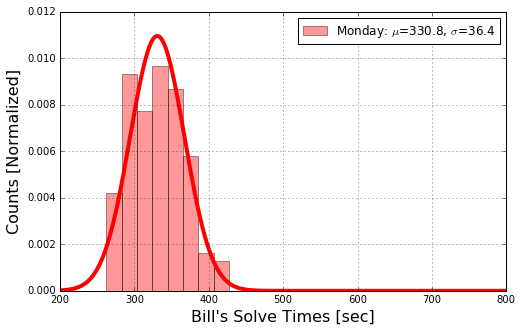

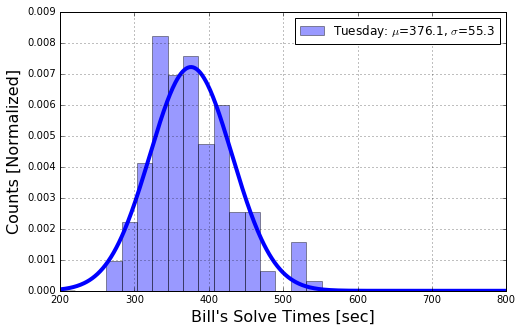

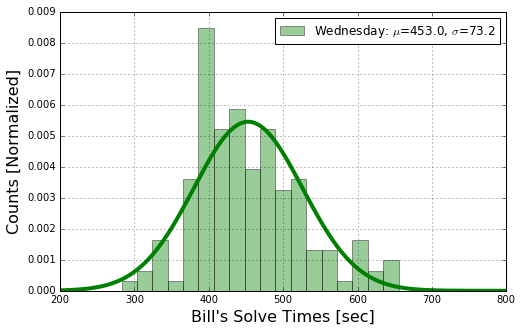

In [6]:
means_errs = {}
bins = np.linspace(200,800,30)
colors = {'Monday':'r','Tuesday':'b','Wednesday':'g'}

# Loop over all seven days of the week
for day in viable_days:
    
    # Query the dataframe for only entries corresponding to this particular day of the week
    # and store the times in a numpy array
    times = np.array(mydf.query('Day == "%s"'%day)['Time'])
    
    # Drop the outliers
    times_trunk = reject_outliers(times,m=2)
    print "%s: \tFraction of data removed as outliers = %0.2f%%" % \
        (day,100.*(1.-float(len(times_trunk))/len(times)))
    
    # Fit the data to a normal distribution
    mu, std = norm.fit(times_trunk)
    
    # Store the results of the fit
    means_errs[day] = (mu, std)
    
    # Only plotting the first three days for blog post readability
    if day not in ['Monday', 'Tuesday', 'Wednesday']: continue
        
    # Use matplotlib to actually draw the histogram
    myfig = plt.figure(figsize=(8,5))
    myhist = plt.hist(times_trunk,bins=bins, alpha=0.4, \
                      label='%s: $\mu$=%0.1f, $\sigma$=%0.1f'%(day,mu,std), \
                      normed=True, color=colors[day])

    # Plot the PDF on top of the histogram
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 500)
    p = norm.pdf(x, mu, std)
    dummy = plt.plot(x, p, color=colors[day], linewidth=4)
    dummy = plt.grid(True)
    dummy = plt.xlabel('Bill\'s Solve Times [sec]',fontsize=16)
    dummy = plt.ylabel('Counts [Normalized]',fontsize=16)
    dummy = plt.legend(loc=1)

We can see from the histograms that these data are approximately normal. That makes intuitive sense; Bill is remarkably consistent, and apparently the L.A. Times does a good job at keeping crossword puzzle difficulty consistent for each day of the week as well.

#### The Result

Now to make the money plot. I will plot the mean of the above PDF for each day of the week, and assign to it an uncertainty equal to one standard deviation (that is, if the distributions were truly normal, 68% of the time Bill will solve a puzzle within that band). I hide this code as well (it's very straightforward matplotlib).

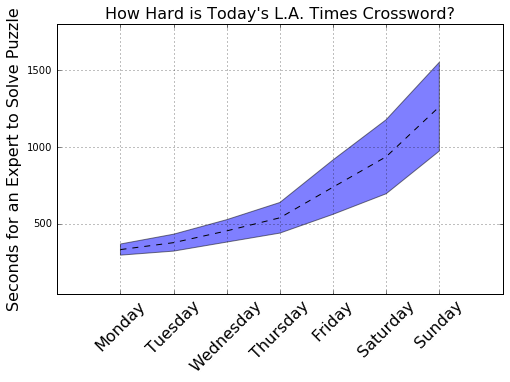

In [7]:
#ignore

plt.figure(figsize=(8,5))
xvals, yvals = [], []
yerrs = []
for x in xrange(len(viable_days)):
    day = viable_days[x]
    xvals.append(x)
    yvals.append(means_errs[day][0])
    yerrs.append(means_errs[day][1])
xvals = np.array(xvals)
yvals = np.array(yvals)
yerrs = np.array(yerrs)
#plt.errorbar(xvals,yvals,yerr=yerrs,fmt='*',color='k')
plt.plot(xvals,yvals,'k--')
plt.fill_between(xvals, yvals+yerrs, yvals-yerrs, facecolor='b', alpha=0.5)
plt.grid(True)
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(xvals, viable_days, rotation=45,fontsize=16)
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.ylabel('Seconds for an Expert to Solve Puzzle',fontsize=16)
dummy = plt.title('How Hard is Today\'s L.A. Times Crossword?',fontsize=16)

Well would you look at that. It's clear that while Monday and Tuesday puzzles are obviously the easiest, Mondays are in fact _not_ harder than Tuesdays. Perhaps when my friend and I solve puzzles there are external factors at play. Maybe starting off on a Monday after a long break leaves us "rusty" and thus slows us down... by the time we get to Tuesdays maybe we're warmed up. Who knows!

I hope you enjoyed this post. Feel free to shoot me an e-mail with comments!